In [1]:
import numpy as np
import os, glob, random

from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.utils import class_weight
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras import layers
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

/home/dl-box/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
#keraswhitebox library
from kwb.utils import deprocess_image
from kwb.model_modification import build_guided_model
from kwb.utils import linearize_activation
from kwb.attention_map import grad_cam, EM

# Requirements

- keras
- skimage
- sklearn
- matplotlib
- keraswhitebox

# Constructing the model with trained weights

In [4]:
K.clear_session()
base_model = InceptionV3(include_top=False, weights=None, input_shape=(224,224,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(38,name='prepredictions')(x)
predictions = layers.Activation('softmax',name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights("resources/models/inceptionv3_plantvillage.hdf5")
model = linearize_activation(model)

linearizing the last layer: predictions


# Load plantvillage data
plantvillage data must be retreived from [here](https://github.com/spMohanty/PlantVillage-Dataset)
run the following function with the root_dir directory specified.

using /plantvillage_deeplearning_paper_dataset-master/raw/color/

In [5]:
def load_plantvillage(seed=None,root_dir=None):
    if root_dir == None:
        print("define where the plantvillage folder is.")
        return

    random.seed(seed)
    
    def read_from_paths(paths):
        x=[]
        for path in paths:
            img = load_img(path, target_size=(224,224))
            img = img_to_array(img) 
            x.append(img)
        return x

    classes = os.listdir(root_dir)
    classes = sorted(classes)
    
    train_path = []
    val_path = []
    test_path = []
    
    train_x,train_y = [],[]
    val_x,val_y = [],[]
    test_x,test_y =[],[]
    
    #read path and categorize to three groups , 6,2,2
    for i,_class in enumerate(classes):
        paths = glob.glob(os.path.join(root_dir,_class,"*"))
        paths = [n for n in paths if n.endswith(".JPG") or n.endswith(".jpg")]
        random.shuffle(paths)
        cat_total = len(paths)
        
        train_path.extend(paths[:int(cat_total*0.6)])
        train_y.extend([i]*int(cat_total*0.6))
        
        val_path.extend(paths[int(cat_total*0.6):int(cat_total*0.8)])
        val_y.extend([i]*len(paths[int(cat_total*0.6):int(cat_total*0.8)]))
        
        test_path.extend(paths[int(cat_total*0.8):])
        test_y.extend([i]*len(paths[int(cat_total*0.8):]))
        
    
    print ("loading images")
    
    train_x = read_from_paths(train_path)
    val_x = read_from_paths(val_path)
    test_x = read_from_paths(test_path)
        
    #convert everything to numpy
    train_x = np.array(train_x)/255.
    train_y = np.array(train_y)
    val_x = np.array(val_x)/255.
    val_y = np.array(val_y)
    test_x = np.array(test_x)/255.
    test_y = np.array(test_y)
    
    #calculate class weight
    classweight = class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)
    
    #convert to categorical
    train_y = np_utils.to_categorical(train_y, 38)
    val_y = np_utils.to_categorical(val_y, 38)
    test_y = np_utils.to_categorical(test_y, 38)
    print("loaded")
    
    return train_x,val_x,test_x,train_y,val_y,test_y,classweight,classes

In [ ]:
_dir = "SOME_PATH" #where the plant village folder is

plantvillage_dir = os.path.join(_dir,"plantvillage_deeplearning_paper_dataset-master/raw/color/")
print(plantvillage_dir)

In [15]:
#will take a while
train_x, val_x, test_x, train_y, val_y, test_y, class_weight, classes \
 = load_plantvillage(seed=7,root_dir=plantvillage_dir)

loading images
loaded


In [33]:
print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

(32570, 224, 224, 3) (10857, 224, 224, 3) (10876, 224, 224, 3)
(32570, 38) (10857, 38) (10876, 38)


# Visualizations introduced in the paper

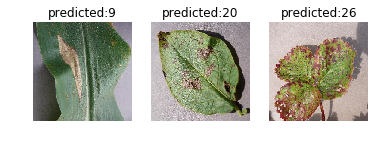

In [6]:
#example images for visualization
paths = ["resources/images/0b112f62-54d5-4395-9f7c-d7ef05290be4___RS_NLB 4196.JPG",
         "resources/images/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG",
        "resources/images/0a08af15-adfe-447c-8ed4-17ed2702d810___RS_L.Scorch 0054.JPG"]

images = []
for path in paths:
    image = load_img(path, target_size=(224,224))
    image = img_to_array(image)/255.
    images.append(image)
    
for i,image in enumerate(images):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.axis("off")
    y_pred = np.argmax(model.predict(image[np.newaxis])[0])
    plt.title("predicted:"+str(y_pred))
    
#predicted class : 9, 20, 26

In [7]:
#build linearized and guided_model
gmodel = build_guided_model(model)

already a linear layer, return unmodified model


# Grad-CAM in different layers

activation_1 

/home/dl-box/anaconda3/envs/keras/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


activation_2 activation_3 activation_4 activation_5 mixed0 mixed1 mixed2 mixed3 mixed4 mixed5 mixed6 mixed7 mixed8 mixed9 mixed10 

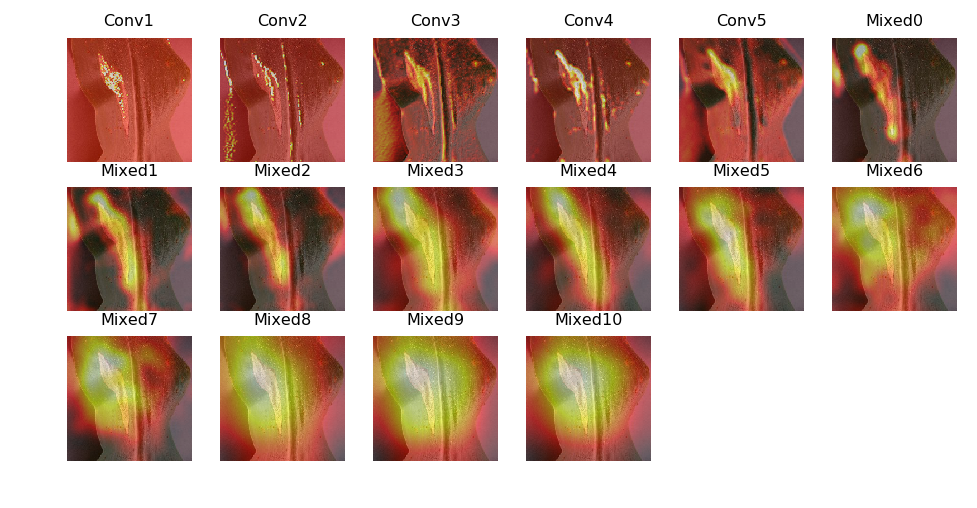

In [12]:
#this is gradcam!!
#run against linear model

%config InlineBackend.figure_formats = {'png', 'retina'}

row = 6
col = 6
plt.figure(figsize=(8, 8)) 

namelayer = ["Conv1","Conv2","Conv3","Conv4","Conv5",
         "Mixed0","Mixed1","Mixed2","Mixed3","Mixed4","Mixed5","Mixed6","Mixed7","Mixed8","Mixed9","Mixed10"]
layer = ["activation_1","activation_2","activation_3","activation_4","activation_5",
         "mixed0","mixed1","mixed2","mixed3","mixed4","mixed5","mixed6","mixed7","mixed8","mixed9","mixed10"]
image = images[0]
for i, (l,n) in enumerate(zip(layer, namelayer)):
    print(l,end=" ")
    if i == (row*col):
        break
    plot_num = i+1
    plt.subplot(row, col, plot_num)
    gc = grad_cam(gmodel,image,l)

    plt.imshow(image)
    plt.imshow(deprocess_image(gc),cmap="hot",alpha=0.5)
    plt.title(n,fontsize=8)
    plt.axis("off")


# Explanation map

activation_1 

/home/dl-box/anaconda3/envs/keras/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


activation_2 activation_3 activation_4 activation_5 mixed0 mixed1 mixed2 mixed3 mixed4 mixed5 mixed6 mixed7 mixed8 mixed9 mixed10 

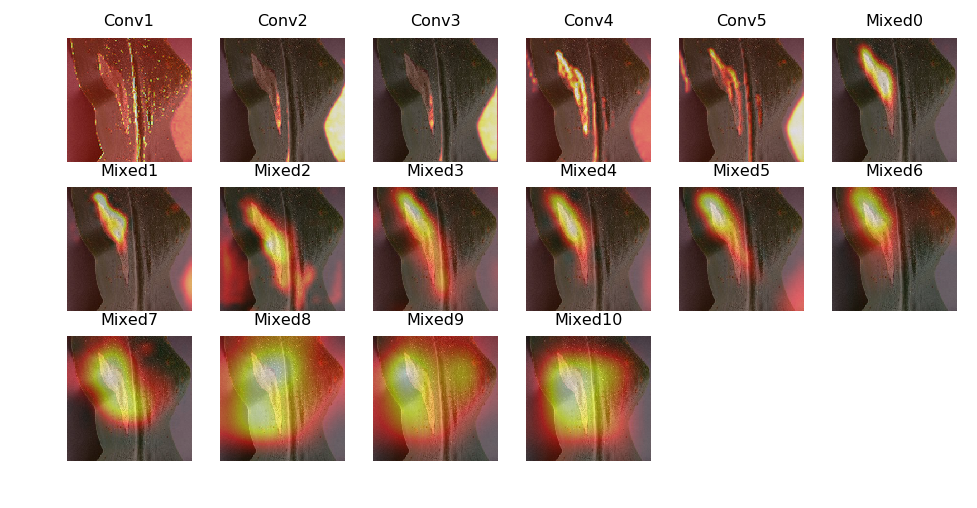

In [16]:
%config InlineBackend.figure_formats = {'png', 'retina'}

row = 6
col = 6
plt.figure(figsize=(8, 8)) 

namelayer = ["Conv1","Conv2","Conv3","Conv4","Conv5",
         "Mixed0","Mixed1","Mixed2","Mixed3","Mixed4","Mixed5","Mixed6","Mixed7","Mixed8","Mixed9","Mixed10"]
layer = ["activation_1","activation_2","activation_3","activation_4","activation_5",
         "mixed0","mixed1","mixed2","mixed3","mixed4","mixed5","mixed6","mixed7","mixed8","mixed9","mixed10"]




# important!! define reference_class
# for images[0], control class is corn healthy leaves of class 10,
# potato 22, strawberry 27, etc...

image = images[0]
ref_class = 10

for i, (l,n) in enumerate(zip(layer, namelayer)):
    print(l,end=" ")
    if i == (row*col):
        break
    plot_num = i+1
    plt.subplot(row, col, plot_num)
    
    #reference_images from test dataset
    ref_images = test_x[np.where(np.argmax(test_y,axis=1) == ref_class)]
    em = EM(model,image,ref_images,layername=l)
    plt.imshow(image)
    plt.imshow(deprocess_image(em),cmap="hot",alpha=0.5)
    plt.title(n,fontsize=8)
    plt.axis("off")

